***Explainer***

This script creates a mask for the different functional areas of interest and identifies the most activated regions in each - ACC, Amygdala, and Striatum.

***Set up environment / Adapt script***

Make sure you run this before running any of the sections!

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
#Set up environment

# Basic
import pandas as pd
import numpy as np
import scipy.io
from os import mkdir, path, getcwd, chdir
from scipy.stats import norm
import pickle
import importlib

%matplotlib inline

# Nipype
from nilearn import plotting
from nipype.interfaces.matlab import MatlabCommand
from nipype import Node, Workflow
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')
from nipype.interfaces.base import Bunch
from nipype.interfaces.spm import EstimateModel
from nipype.interfaces.spm import EstimateContrast
from nipype.interfaces.spm import Normalize12
from nipype import SelectFiles
from nipype.algorithms.misc import Gunzip
from nipype.interfaces.io import DataSink
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces.spm import Level1Design

# Nilearn
import nilearn
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show, plot_glass_brain
import matplotlib.pyplot as plt
from nilearn import input_data
from nilearn import image as nli
from nilearn.image import mean_img
from nilearn import input_data
from nilearn.glm.first_level import first_level_from_bids
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.reporting import get_clusters_table
from nilearn.image import threshold_img
from nilearn.datasets import fetch_atlas_harvard_oxford
from nilearn.image import coord_transform


#Utils - reload each time in case new function were added
import util
importlib.reload(util) 
import util
import eventfiles_wMot
importlib.reload(eventfiles_wMot) 
import eventfiles_wMot
import eventfiles
importlib.reload(eventfiles) 
import eventfiles


***Initialize paths and subjects***

In [4]:
#Paths
behav_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/task/stimuli_and_log/Log'
mri_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI data'
output_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis/Output'
main_path = 'C:/Users/maxb.WISMAIN/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis'

# behav_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/task/stimuli_and_log/Log'
# mri_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI data'
# output_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis/Output'
# main_path = 'C:/Users/maxab/Dropbox (Weizmann Institute)/Max-and-Ella/MRI Analysis'

#Turn 1 if you're only addinhg new regions but not new subjects
newRegion = 0

#Settings for processing
get_events = eventfiles.DecisionStim #other options: 'DecisionStim' 'Decision200' 'Decision0' 'DecisionDur' 'facePairs'
fName = 'DecisionStim'
create_DesignMatrix = util.create_DesignMatrix_Decision #option 2: 'facePairs'
grChoice = 'day' #day, night, both'

#Define Subjects
day_list = np.arange(1201,1246)
day_list = np.delete(day_list,[1,8,21,25,26])
night_list = np.arange(1101,1145)
night_list = np.delete(night_list,[0,1,4,9,10,15,17,21,23,25,33,36,39,40,43])


In [5]:
#Choose sub list for each group or both groups
if grChoice == 'day':
    sub_list = day_list
elif grChoice == 'night':
    sub_list  = night_list
elif grChoice == 'both':
    sub_list = np.concatenate((day_list,night_list),axis=None)


#Switch to correct path
chdir(main_path)

#Check if path for particular GLM was created
if not path.exists("Output/{}".format(fName)):
    mode = 0o666
    curr_path = path.join(output_path, fName)
    mkdir(curr_path, mode)
else:
    curr_path = path.join(output_path, fName)
    

***Get list of names***

In [13]:
#Get list of subNames 
df = pd.read_excel(mri_path+'/subjects numbers and scans.xlsx',usecols=[2,3],index_col=0,header=None).to_dict()[3]
subNames = []

for subNum, subName in df.items():
    if np.isin(subNum,sub_list):
        subNames.append(subName)


***Fetch atlas and choose regions for masking***

In [6]:
#Define number of most activated voxels per region
K = 3

#get atlas
atlas_cort = fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_sub = fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

#Fetch ROI maps from CheckBrainAreas script
try:
    brainAreas
except NameError:
    ROIALL_file = open("{}/{}_allROIs_{}.pkl".format(curr_path,grChoice,fName), "rb")
    brainAreas = pickle.load(ROIALL_file)
    ROIALL_file.close()

#Check to see if there are new areas involved

if newRegion == 1:
    try:
        ROI_maps
    except NameError:
        ROIs_file = open("{}/{}_ROI_maps_{}.pkl".format(curr_path,grChoice,fName), "rb")
        ROI_maps = pickle.load(ROIs_file)
        ROIs_file.close()

    curr_areas = list(brainAreas.keys())    
        
    prev_areas = list(ROI_maps['1']['negposReward'].keys())

    new_areas = set(curr_areas).symmetric_difference(set(prev_areas))
    new_areas = list(new_areas)

    brainAreas_trans = {area_key: brainAreas[area_key] for area_key in new_areas}
    brainAreas = brainAreas_trans


***Get thresholded z-maps***

In [7]:
#Run 1

try:
    thres1_map
except NameError:
    thres1_file = open("{}/{}_thres1_dict_{}.pkl".format(curr_path,grChoice,fName), "rb")
    thres1_map = pickle.load(thres1_file)
    thres1_file.close()

#Run 2
    
try:
    thres2_map
except NameError:
    thres2_file = open("{}/{}_thres2_dict_{}.pkl".format(curr_path,grChoice,fName), "rb")
    thres2_map = pickle.load(thres2_file)
    thres2_file.close()
    
#Run ALL    
    
try:
    thresALL_map
except NameError:
    thresALL_file = open("{}/{}_thresALL_dict_{}.pkl".format(curr_path,grChoice,fName), "rb")
    thresALL_map = pickle.load(thresALL_file)
    thresALL_file.close()



***Get most activated voxels***

In [10]:
#need to rewrite this more elaborately

if newRegion != 1:
    kVoxels = {}
    kVoxels['1'] = {}
    kVoxels['2'] = {}
    kVoxels['ALL'] = {}
    kIndices = {}
    kIndices['1'] = {}
    kIndices['2'] = {}
    kIndices['ALL'] = {}
    ROI_maps = {}
    ROI_maps['1'] = {}
    ROI_maps['2'] = {}
    ROI_maps['ALL'] = {}
elif newRegion == 1:
    kVox_file = open("{}/{}_kVoxels_{}.pkl".format(curr_path,grChoice,fName), "rb")
    kVoxels = pickle.load(kVox_file)
    kVox_file.close()
    kInd_file = open("{}/{}_kIndices_{}.pkl".format(curr_path,grChoice,fName), "rb")
    kIndices = pickle.load(kInd_file)
    kInd_file.close()    
    ROIs_file = open("{}/{}_ROI_maps_{}.pkl".format(curr_path,grChoice,fName), "rb")
    ROI_maps = pickle.load(ROIs_file)
    ROIs_file.close()


DM = create_DesignMatrix()
contrasts = {key:[] for key in DM}

for df in ['ALL']:
    
    print('  For run %s ...' % (df))
    
    if newRegion != 1:
        kVoxels[df] = {key:[] for key in DM}
        ROI_maps[df] = {key:[] for key in DM}
        kIndices[df] = {key:[] for key in DM}
    
    for index1, (contrast_id, contrast_val) in enumerate(contrasts.items()):
        
        print('  Contrast % 2i out of %i: %s' % (
            index1 + 1, len(contrasts), contrast_id))
        if newRegion != 1:
            ROI_maps[df][contrast_id] = {key:[] for key in brainAreas}
            kVoxels[df][contrast_id] = {key:[] for key in brainAreas}
            kIndices[df][contrast_id] = {key:[] for key in brainAreas}
        
        for index2, (area,subarea) in enumerate(brainAreas.items()):

            print('  Fit %s from atlas and get k voxels ' % (area))

            #Get area and zmap
            area_logic = np.logical_or(brainAreas[area]['Left'], brainAreas[area]['Right'])
            mean_scan = globals()[f"thres{df}_map"][contrast_id][0] 

            #Save brain area boolean in image and resample output to brain scan
            img_from_atlas = nilearn.image.new_img_like(atlas_cort.maps,area_logic)
            img_from_atlas_resampled = nilearn.image.resample_to_img(img_from_atlas, mean_scan, interpolation = 'nearest')

            #Fit, transform and inverse
            masker_from_resampled = nilearn.input_data.NiftiMasker(mask_img=img_from_atlas_resampled).fit()
            masked_mean_img_from_resampled = masker_from_resampled.transform_single_imgs(mean_scan) 
            masked_mean_img_from_resampled_inverse = masker_from_resampled.inverse_transform(masked_mean_img_from_resampled)

            #Save first mask of ROIs for plotting
            ROI_maps[df][contrast_id][area] = masked_mean_img_from_resampled_inverse
                
            image_as_array = nilearn.image.get_data(masked_mean_img_from_resampled_inverse)
            ind = np.unravel_index(np.argsort(image_as_array, axis=None), image_as_array.shape)

            all_coords = []
            all_xyzs = []
            
            for i in range(1,K+1):
                x = ind[0][-i]
                y = ind[1][-i]
                z = ind[2][-i]
                coords = coord_transform(x, y, z,
                                         affine=masked_mean_img_from_resampled_inverse.affine)
                
                all_coords.append(coords)
                all_xyzs.append((x,y,z))
            
            kVoxels[df][contrast_id][area] = all_coords
            kIndices[df][contrast_id][area] = all_xyzs
    
kVox_file = open("{}/{}_kVoxels_{}.pkl".format(curr_path,grChoice,fName), "wb")
pickle.dump(kVoxels, kVox_file)
kVox_file.close()
kInd_file = open("{}/{}_kIndices_{}.pkl".format(curr_path,grChoice,fName), "wb")
pickle.dump(kIndices, kInd_file)
kInd_file.close()
ROIs_file = open("{}/{}_ROI_maps_{}.pkl".format(curr_path,grChoice,fName), "wb")
pickle.dump(ROI_maps, ROIs_file)
ROIs_file.close()

print('Done!')


  For run ALL ...
  Contrast  1 out of 6: negposReward
  Fit Amygdala from atlas and get k voxels 
  Fit Accumbens from atlas and get k voxels 
  Fit Precuneous from atlas and get k voxels 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit Subcallosal cortex from atlas and get k voxels 
  Fit Paracingulate gyrus from atlas and get k voxels 
  Fit Posterior cingulate gyrus from atlas and get k voxels 
  Fit Ant sup temp gyrus from atlas and get k voxels 
  Contrast  2 out of 6: neutnegReward
  Fit Amygdala from atlas and get k voxels 
  Fit Accumbens from atlas and get k voxels 
  Fit Precuneous from atlas and get k voxels 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit Subcallosal cortex from atlas and get k voxels 
  Fit Paracingulate gyrus from atlas and get k voxels 
  Fit Posterior cingulate gyrus from atlas and get k voxels 
  Fit Ant sup temp gyrus from atlas and get k voxels 
  Contrast  3 out of 6: posneutReward
  Fit Amygdala from atlas and get k voxel

***Load ROIs if necessary***

In [11]:
try:
    kVoxels
except NameError:
    kVox_file = open("{}/{}_kVoxels_{}.pkl".format(curr_path,grChoice,fName), "rb")
    kVoxels = pickle.load(kVox_file)
    kVox_file.close()
    
try:
    ROI_maps
except NameError:
    ROIs_file = open("{}/{}_ROI_maps_{}.pkl".format(curr_path,grChoice,fName), "rb")
    ROI_maps = pickle.load(ROIs_file)
    ROIs_file.close()
    
try:
    brainAreas
except NameError:
    ROIALL_file = open("{}/{}_allROIs_{}.pkl".format(curr_path,grChoice,fName), "rb")
    brainAreas = pickle.load(ROIALL_file)
    ROIALL_file.close()

***Check that locations of most-activated voxels are sensible***

  Contrast negposReward 
  Plot most activated voxel for Amygdala


C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\img_plotting.py:348: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  anat_img = load_mni152_template()


  Plot most activated voxel for Accumbens
  Plot most activated voxel for Precuneous
  Plot most activated voxel for Frontomedial cortex
  Plot most activated voxel for Subcallosal cortex
  Plot most activated voxel for Paracingulate gyrus
  Plot most activated voxel for Posterior cingulate gyrus
  Plot most activated voxel for Ant sup temp gyrus
  Contrast neutnegReward 
  Plot most activated voxel for Amygdala
  Plot most activated voxel for Accumbens
  Plot most activated voxel for Precuneous
  Plot most activated voxel for Frontomedial cortex
  Plot most activated voxel for Subcallosal cortex
  Plot most activated voxel for Paracingulate gyrus
  Plot most activated voxel for Posterior cingulate gyrus
  Plot most activated voxel for Ant sup temp gyrus
  Contrast posneutReward 
  Plot most activated voxel for Amygdala


C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\displays\_slicers.py:373: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


  Plot most activated voxel for Accumbens
  Plot most activated voxel for Precuneous
  Plot most activated voxel for Frontomedial cortex
  Plot most activated voxel for Subcallosal cortex


C:\Users\maxb.WISMAIN\Anaconda3\lib\site-packages\nilearn\plotting\displays\_slicers.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure(figure, figsize=figsize,


  Plot most activated voxel for Paracingulate gyrus
  Plot most activated voxel for Posterior cingulate gyrus
  Plot most activated voxel for Ant sup temp gyrus
  Contrast negposFace 
  Plot most activated voxel for Amygdala
  Plot most activated voxel for Accumbens
  Plot most activated voxel for Precuneous
  Plot most activated voxel for Frontomedial cortex
  Plot most activated voxel for Subcallosal cortex
  Plot most activated voxel for Paracingulate gyrus
  Plot most activated voxel for Posterior cingulate gyrus
  Plot most activated voxel for Ant sup temp gyrus
  Contrast neutnegFace 
  Plot most activated voxel for Amygdala
  Plot most activated voxel for Accumbens
  Plot most activated voxel for Precuneous
  Plot most activated voxel for Frontomedial cortex
  Plot most activated voxel for Subcallosal cortex
  Plot most activated voxel for Paracingulate gyrus
  Plot most activated voxel for Posterior cingulate gyrus
  Plot most activated voxel for Ant sup temp gyrus
  Contrast p

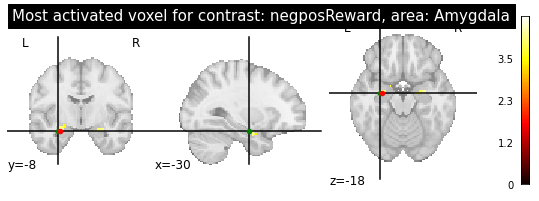

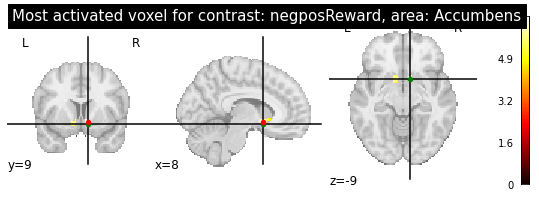

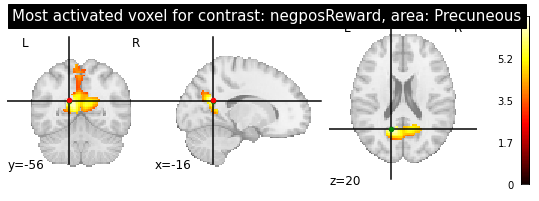

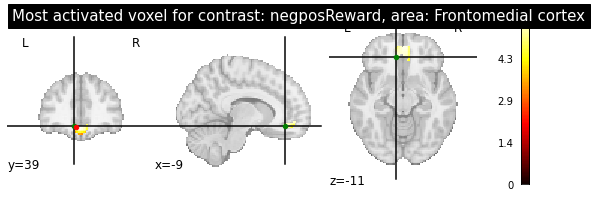

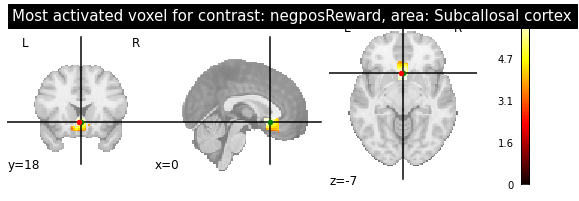

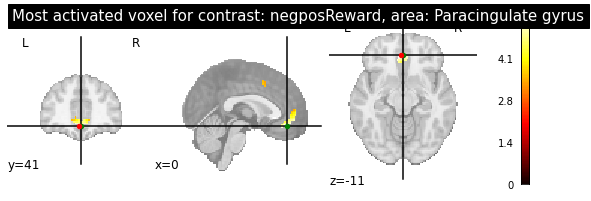

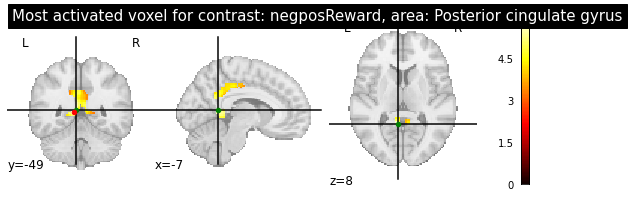

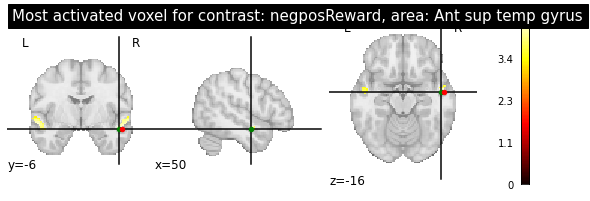

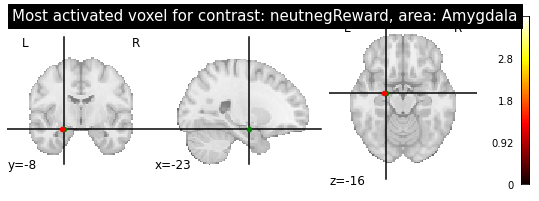

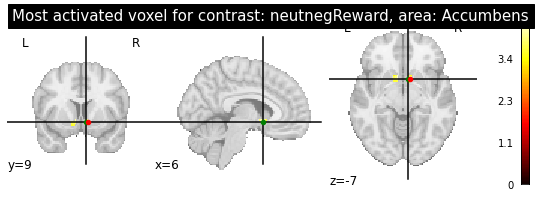

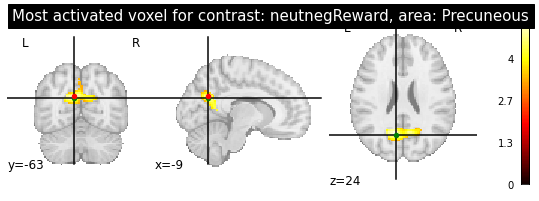

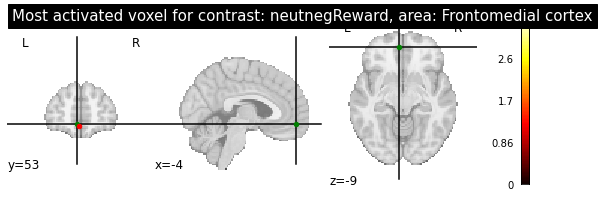

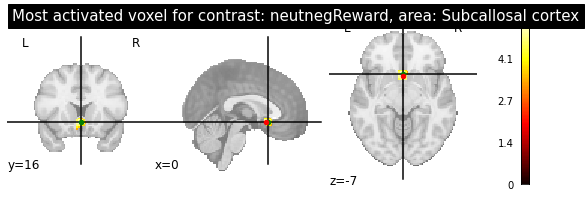

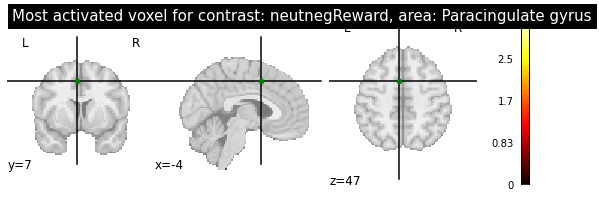

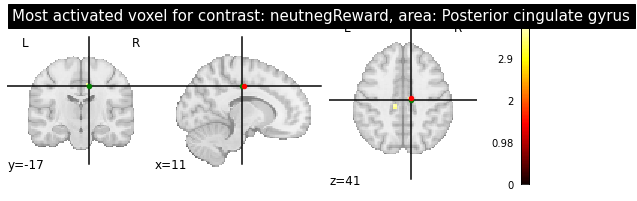

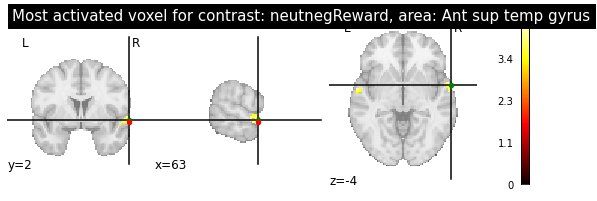

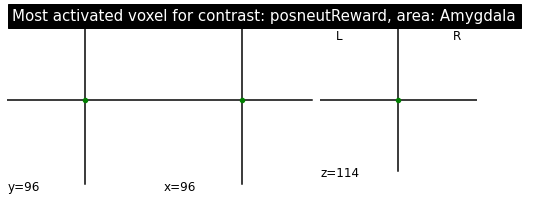

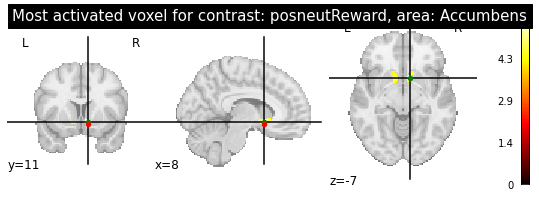

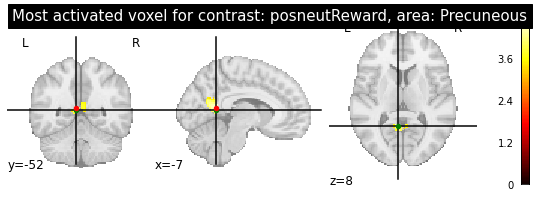

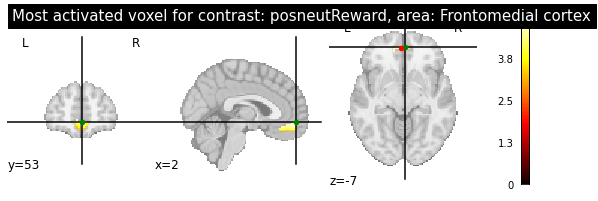

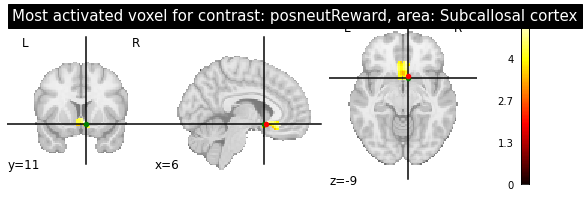

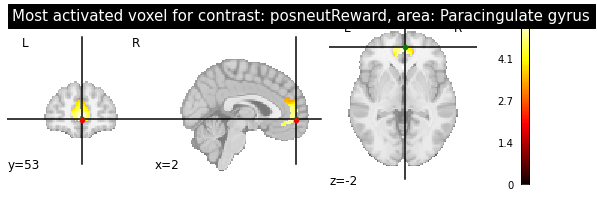

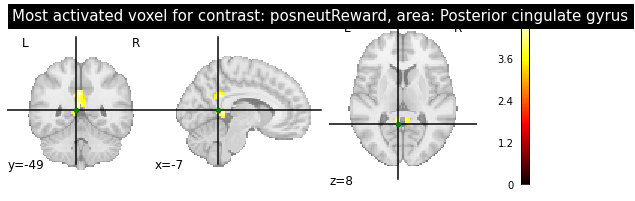

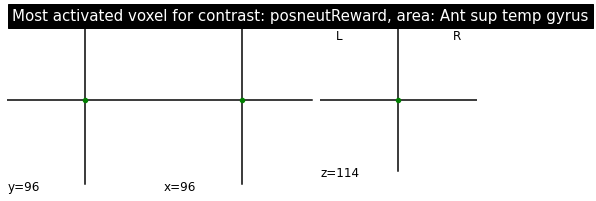

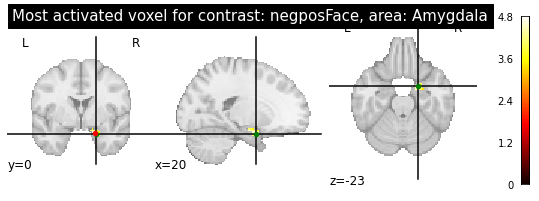

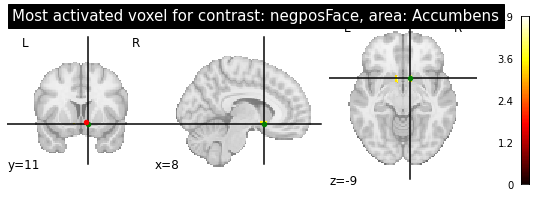

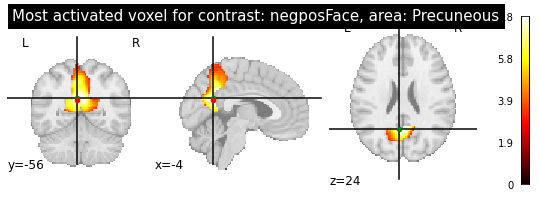

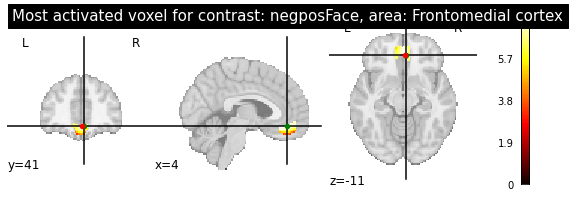

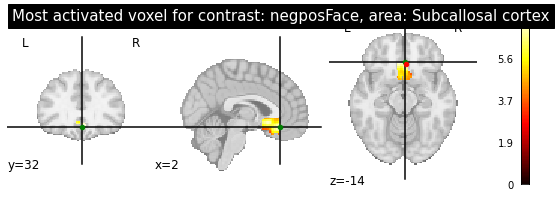

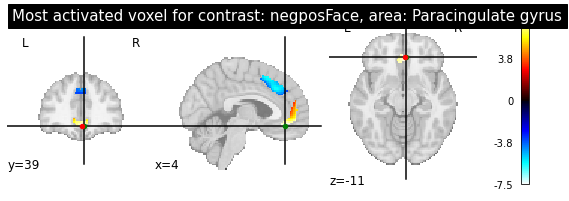

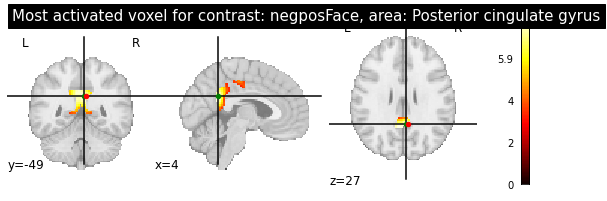

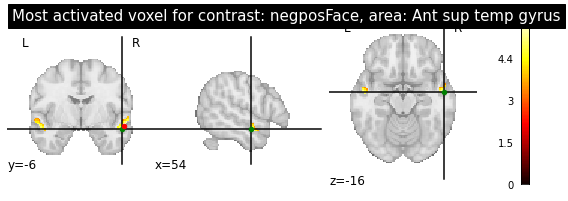

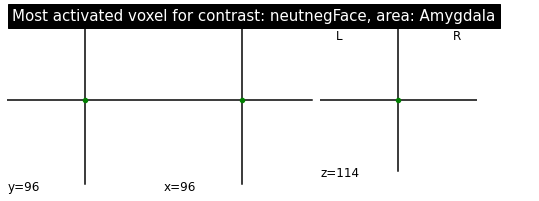

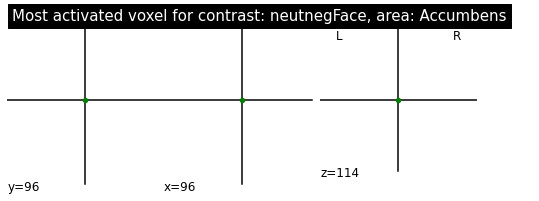

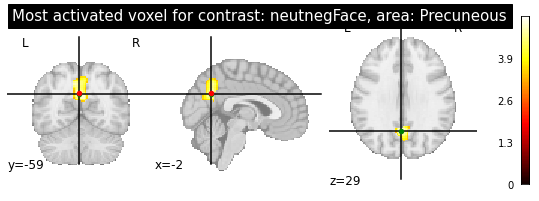

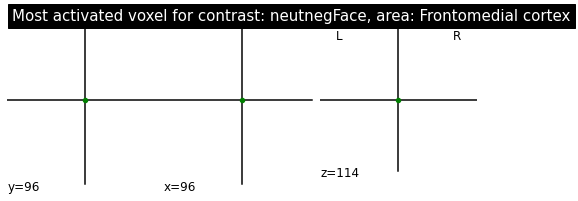

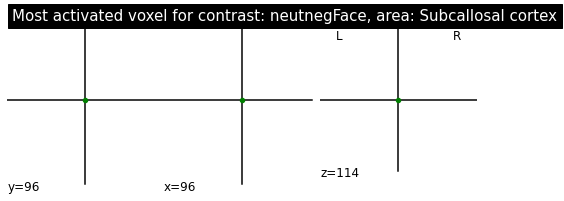

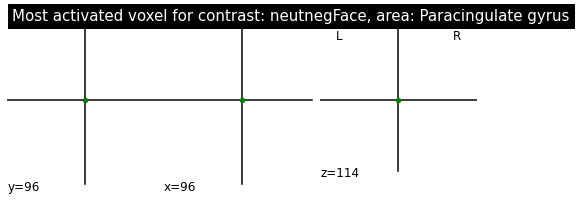

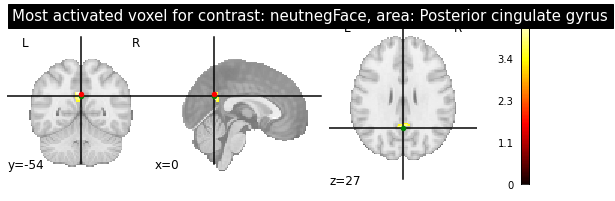

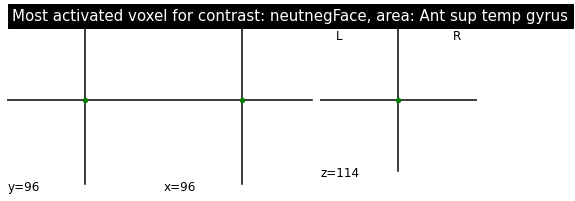

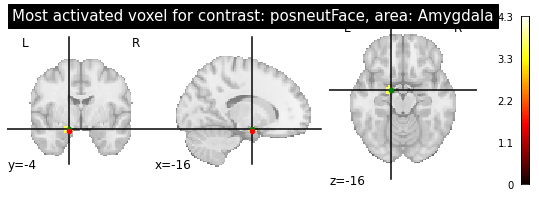

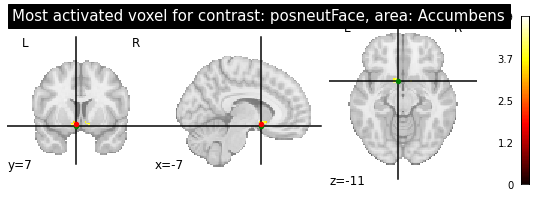

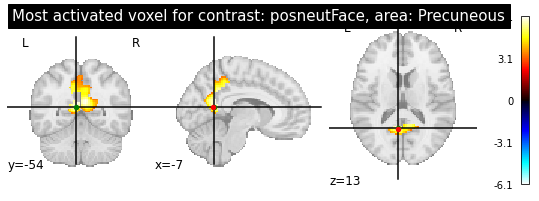

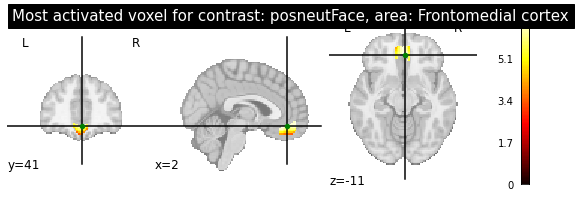

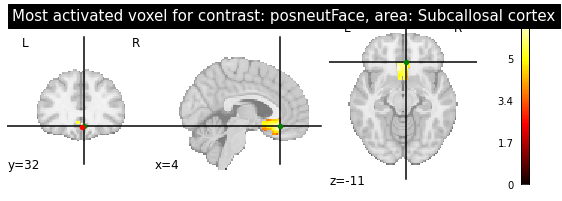

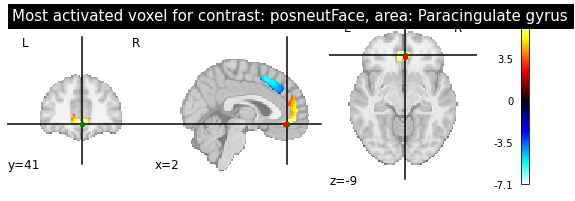

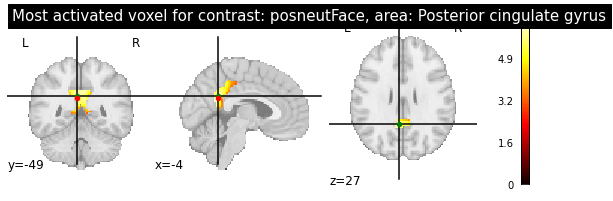

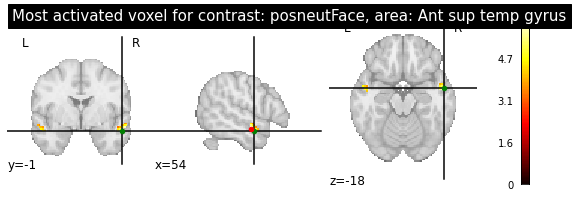

In [12]:
df = 'ALL'
contrasts = create_DesignMatrix()
for index1, (contrast_id, contrast_val) in enumerate(contrasts.items()):
    
    print('  Contrast %s ' % (contrast_id))

    for index, (area,subarea) in enumerate(brainAreas.items()):

        print('  Plot most activated voxel for %s' % (area))
        coords = [kVoxels[df][contrast_id][area][0]]
        coords2 = [kVoxels[df][contrast_id][area][1]]
        curr_map = ROI_maps[df][contrast_id][area]
        display = plotting.plot_stat_map(curr_map,
                                         cut_coords=coords[0],
                                         title="Most activated voxel for contrast: "+contrast_id+", area: "+area
                                         )
        display.add_markers(marker_coords=coords, marker_color='g',
                            marker_size=20)
        display.add_markers(marker_coords=coords2, marker_color='r',
                    marker_size=20)


***Load zmaps for each subject***

In [14]:
#Load all zmaps in loop

cnt = 0
for subName in subNames:
    print("Saving zmaps in list for subject " + subName)
    cnt += 1
    z_file = open("{}/{}_z1_map_{}.pkl".format(curr_path,subName,fName), "rb")
    allZs = pickle.load(z_file)
    z_file.close()
    
    if cnt == 1:
        z_map1 = {} 
        z_map2 = {} 
        z_mapALL = {} 

    
    for contrast in allZs[1].keys():
        
        if cnt == 1:
            z_map1[contrast] = []
            z_map2[contrast] = []
            z_mapALL[contrast] = []

        z_map1[contrast].append(allZs[1][contrast])
        z_map2[contrast].append(allZs[2][contrast])
        z_mapALL[contrast].append(allZs[1][contrast])
        z_mapALL[contrast].append(allZs[2][contrast])
                
print("DONE!")    

Saving zmaps in list for subject KO288
Saving zmaps in list for subject WB012
Saving zmaps in list for subject HN802
Saving zmaps in list for subject MA099
Saving zmaps in list for subject KS959
Saving zmaps in list for subject YP703
Saving zmaps in list for subject HI971
Saving zmaps in list for subject DL641
Saving zmaps in list for subject SO902
Saving zmaps in list for subject BS840
Saving zmaps in list for subject RN527
Saving zmaps in list for subject CR586
Saving zmaps in list for subject KA118
Saving zmaps in list for subject VA138
Saving zmaps in list for subject HN732
Saving zmaps in list for subject BR119
Saving zmaps in list for subject RG137
Saving zmaps in list for subject BR122
Saving zmaps in list for subject SS952
Saving zmaps in list for subject TI792
Saving zmaps in list for subject KH261
Saving zmaps in list for subject CD864
Saving zmaps in list for subject MA257
Saving zmaps in list for subject AO822
Saving zmaps in list for subject LB218
Saving zmaps in list for 

***Get ROI masks***

In [18]:
atlas_cort = fetch_atlas_harvard_oxford('cortl-maxprob-thr25-2mm')
atlas_sub = fetch_atlas_harvard_oxford('sub-maxprob-thr25-2mm')

sampleIMG = thresALL_map['negposFace'][0] #Take image from any subject
ROImasks = {}

for area in ROI_maps['ALL']['negposFace']:

    #Get area image as logical
    area_logic = np.logical_or(brainAreas[area]['Left'], brainAreas[area]['Right'])

    #Save brain area boolean in image and resample output to brain scan
    img_from_atlas = nilearn.image.new_img_like(atlas_cort.maps,area_logic)
    img_from_atlas_resampled = nilearn.image.resample_to_img(img_from_atlas, sampleIMG, interpolation = 'nearest')

    #Store in dict
    ROImasks[area] = img_from_atlas_resampled


***Get activity for most activated voxels for each subject - adapt this***

In [ ]:
if newRegion != 1:
    subjectActivity = {}
elif newRegion == 1:
    subjectActivity_file = open("{}/subjectActivity_{}.pkl".format(curr_path,fName), "rb")
    subjectActivity = pickle.load(subjectActivity_file)
    subjectActivity_file.close()
    
for df in list(kVoxels.keys())[0:2]:
    print('  For run %s ...' % (df))
    if newRegion != 1:
        subjectActivity[df] = {}
    for contrast in kVoxels['ALL'].keys():
        print('  Contrast: %s' % (contrast))
        if newRegion != 1:
            subjectActivity[df][contrast] = {}
        for index2, (area,subarea) in enumerate(brainAreas.items()):    
            print('  Fit %s from atlas and get k voxels ' % (area))
            subjectActivity[df][contrast][area] = {}
            
            #Insert here choice of coord: first or mean of first and second
            xyz = kVoxels['ALL'][contrast][area][0]
            sphere3Mask = input_data.NiftiSpheresMasker([xyz], radius = 3, mask_img = ROImasks[area])
            sphere50Mask = input_data.NiftiSpheresMasker([xyz], radius = 5, mask_img = ROImasks[area])
            ROIMask = input_data.NiftiMasker(mask_img = ROImasks[area])
            subjectActivity[df][contrast][area]['Voxels'] = []
            subjectActivity[df][contrast][area]['Sphere3'] = []
            subjectActivity[df][contrast][area]['Sphere5'] = []
            subjectActivity[df][contrast][area]['ROI'] = [] 
            for ind, num in enumerate(sub_list):
                print('  Fit %s from atlas and get voxel ' % (num))
                single_scan = globals()[f"z_map{df}"][contrast][ind]
                inds = kIndices['ALL'][contrast][area][0]
                image_as_array = nilearn.image.get_data(single_scan)
                voxVal = image_as_array[inds[0],inds[1],inds[2]]
                subjectActivity[df][contrast][area]['Voxels'].append(voxVal)
                if voxVal != 0:
                    subjectActivity[df][contrast][area]['Sphere3'].append(sphere3Mask.fit_transform(single_scan)[0][0])
                    subjectActivity[df][contrast][area]['Sphere5'].append(sphere5Mask.fit_transform(single_scan)[0][0])
                    subjectActivity[df][contrast][area]['ROI'].append(np.mean(ROIMask.fit_transform(single_scan)[0][0]))           
                elif voxVal == 0:
                    subjectActivity[df][contrast][area]['Sphere3'].append(0)
                    subjectActivity[df][contrast][area]['Sphere5'].append(0)
                    subjectActivity[df][contrast][area]['ROI'].append(0)
                

  For run 1 ...
  Contrast: negposReward
  Fit Amygdala from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and g

  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
  Fit 1234 from atlas and get voxel 
  Fit 1235 from atlas and get voxel 
  Fit 1236 from atlas and get voxel 
  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
 

  Fit 1233 from atlas and get voxel 
  Fit 1234 from atlas and get voxel 
  Fit 1235 from atlas and get voxel 
  Fit 1236 from atlas and get voxel 
  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atla

  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
 

  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
  Fit 1234 from atlas and get voxel 
  Fit 1235 from atlas and get voxel 
  Fit 1236 from atlas and get voxel 
  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
  Fit Ant sup temp gyrus from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 from atlas

  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
  Fit Subcallosal cortex from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas

  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
 

  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atlas and get voxel 
  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
 

  Fit 1219 from atlas and get voxel 
  Fit 1220 from atlas and get voxel 
  Fit 1221 from atlas and get voxel 
  Fit 1223 from atlas and get voxel 
  Fit 1224 from atlas and get voxel 
  Fit 1225 from atlas and get voxel 
  Fit 1228 from atlas and get voxel 
  Fit 1229 from atlas and get voxel 
  Fit 1230 from atlas and get voxel 
  Fit 1231 from atlas and get voxel 
  Fit 1232 from atlas and get voxel 
  Fit 1233 from atlas and get voxel 
  Fit 1234 from atlas and get voxel 
  Fit 1235 from atlas and get voxel 
  Fit 1236 from atlas and get voxel 
  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
  Fit Posterior cingulate gyrus from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 fro

  Fit 1236 from atlas and get voxel 
  Fit 1237 from atlas and get voxel 
  Fit 1238 from atlas and get voxel 
  Fit 1239 from atlas and get voxel 
  Fit 1240 from atlas and get voxel 
  Fit 1241 from atlas and get voxel 
  Fit 1242 from atlas and get voxel 
  Fit 1243 from atlas and get voxel 
  Fit 1244 from atlas and get voxel 
  Fit 1245 from atlas and get voxel 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit 1201 from atlas and get voxel 
  Fit 1203 from atlas and get voxel 
  Fit 1204 from atlas and get voxel 
  Fit 1205 from atlas and get voxel 
  Fit 1206 from atlas and get voxel 
  Fit 1207 from atlas and get voxel 
  Fit 1208 from atlas and get voxel 
  Fit 1210 from atlas and get voxel 
  Fit 1211 from atlas and get voxel 
  Fit 1212 from atlas and get voxel 
  Fit 1213 from atlas and get voxel 
  Fit 1214 from atlas and get voxel 
  Fit 1215 from atlas and get voxel 
  Fit 1216 from atlas and get voxel 
  Fit 1217 from atlas and get voxel 
  Fit 1218 from atla

***Average first and second run***

In [266]:
df = 'ALL'
print('  For run %s ...' % (df))
subjectActivity[df] = {}
for contrast in kVoxels['1'].keys():
    print('  Contrast: %s' % (contrast))
    if newRegion != 1:
        subjectActivity[df][contrast] = {}
    for index2, (area,subarea) in enumerate(brainAreas.items()):    
        print('  Fit %s from atlas and get k voxels ' % (area))
        subjectActivity[df][contrast][area] = {}  
        #Mean voxels from both sessions
        voxa, voxb = np.array(subjectActivity['1'][contrast][area]['Voxels']), np.array(subjectActivity['2'][contrast][area]['Voxels']) 
        voxmean = (voxa + voxb)/2
        subjectActivity['ALL'][contrast][area]['Voxels'] = list(voxmean)
        #Mean 3mmm-spheres from both sessions
        spha, sphb = np.array(subjectActivity['1'][contrast][area]['Sphere3']), np.array(subjectActivity['2'][contrast][area]['Sphere3']) 
        sphmean = (spha + sphb)/2
        subjectActivity['ALL'][contrast][area]['Sphere3'] = list(sphmean)
        #Mean 5mmm-spheres from both sessions
        spha, sphb = np.array(subjectActivity['1'][contrast][area]['Sphere5']), np.array(subjectActivity['2'][contrast][area]['Sphere5']) 
        sphmean = (spha + sphb)/2
        subjectActivity['ALL'][contrast][area]['Sphere5'] = list(sphmean)
        #Mean whole ROI from both sessions
        spha, sphb = np.array(subjectActivity['1'][contrast][area]['ROI']), np.array(subjectActivity['2'][contrast][area]['ROI']) 
        sphmean = (spha + sphb)/2
        subjectActivity['ALL'][contrast][area]['ROI'] = list(sphmean)
        

#Save
subAct_file = open("{}/{}_subjectActivity_{}.pkl".format(curr_path,grChoice,fName), "wb")
pickle.dump(subjectActivity, subAct_file)
subAct_file.close()

  For run ALL ...
  Contrast: negposReward
  Fit Amygdala from atlas and get k voxels 
  Fit Accumbens from atlas and get k voxels 
  Fit Precuneous from atlas and get k voxels 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit Subcallosal cortex from atlas and get k voxels 
  Fit Paracingulate gyrus from atlas and get k voxels 
  Fit Posterior cingulate gyrus from atlas and get k voxels 
  Fit Ant sup temp gyrus from atlas and get k voxels 
  Contrast: neutnegReward
  Fit Amygdala from atlas and get k voxels 
  Fit Accumbens from atlas and get k voxels 
  Fit Precuneous from atlas and get k voxels 
  Fit Frontomedial cortex from atlas and get k voxels 
  Fit Subcallosal cortex from atlas and get k voxels 
  Fit Paracingulate gyrus from atlas and get k voxels 
  Fit Posterior cingulate gyrus from atlas and get k voxels 
  Fit Ant sup temp gyrus from atlas and get k voxels 
  Contrast: posneutReward
  Fit Amygdala from atlas and get k voxels 
  Fit Accumbens from atlas and ge

***Save in -.exc file***

(Make sure excel files are closed!)

In [267]:
#All session data frame
curr_dictALL = subjectActivity['ALL']
[flat_dictALL] = pd.json_normalize(curr_dictALL, sep='_').to_dict(orient='records')
dfALL = pd.DataFrame(flat_dictALL)
dfALL.insert(0, 'SubNum', sub_list.tolist())
dfALL.to_excel('{}/subjectActivityALL_{}.xlsx'.format(curr_path,fName))
